In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference
import autograd.numpy.random as npr

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

# Problem Definition

In [160]:
# define ODE problem
# 2 species Lotka–Volterra equations

def f(t, y):
    # du/dt = au -buv
    # dv/dt = -cv + dbu*v
    # http://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
    a = 1.
    b = 0.1
    c = 1.5
    d = 0.75
    return [a*y[0] - b*y[0]*y[1], -c*y[1]+d*b*y[0]*y[1]]

t = np.linspace(0, 10, 100).reshape(-1, 1) #increase training points

y0_list = [5, 10] # number of prey and predactor respectively

# Reference solution

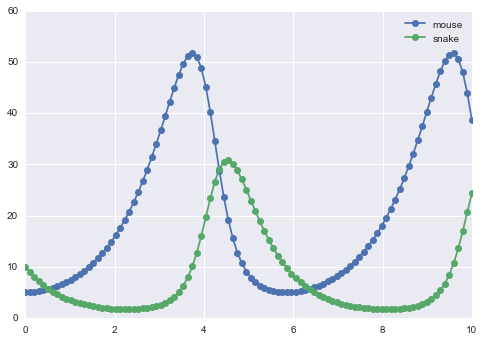

In [161]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='mouse')
plt.plot(sol.t, sol.y[1], marker='o', label='snake')
#plt.plot(sol.t, sol.y[2], marker = 'o', label = 'owl')
plt.legend()

# Neural Net Training

In [170]:
nn = NNSolver(f, t, y0_list, n_hidden=50)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [5, 10] 
Numnber of hidden units:   50 
Number of training points: 100 

In [171]:
nn.reset_weights()
%time nn.train(maxiter=500, iprint=100)

iteration: 0 loss:  6426.51632005
iteration: 100 loss:  1.68750704091
iteration: 200 loss:  0.635253415149
iteration: 300 loss:  0.154927638416
iteration: 400 loss:  0.0178266987034
         Current function value: 0.014244
         Iterations: 500
         Function evaluations: 591
         Gradient evaluations: 591
CPU times: user 12.5 s, sys: 390 ms, total: 12.9 s
Wall time: 10.1 s


# Verifying training set

In [172]:
y_pred_list, dydt_pred_list = nn.predict()

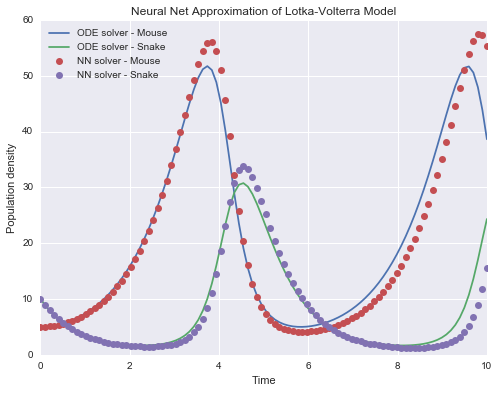

In [173]:
#y_pred_list, dydt_pred_list = nn.predict()
plt.figure(figsize= (8, 6))
# scipy sol
plt.plot(sol.t, sol.y[0], label='ODE solver - Mouse')
plt.plot(sol.t, sol.y[1], label='ODE solver - Snake')
#plt.plot(sol.t, sol.y[2], label='ODE solver - Owl')
# nn soln

plt.plot(t, y_pred_list[0], 'o', label='NN solver - Mouse')


plt.plot(t, y_pred_list[1], 'o', label='NN solver - Snake')


#plt.plot(t, y_pred_list[2], 'o', label='NN - Owl')

plt.legend(loc = "best")
plt.title('Neural Net Approximation of Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population density')
#plt.xlim((0, 10.1))

In [175]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)])
#rms = sqrt(mean_squared_error(sol.y[0], y_pred_list[0]))
#sqrt(mean_squared_error(sol.y[1], y_pred_list[1])) + sqrt(mean_squared_error(sol.y[0], y_pred_list[0]))

2.7461792320281737

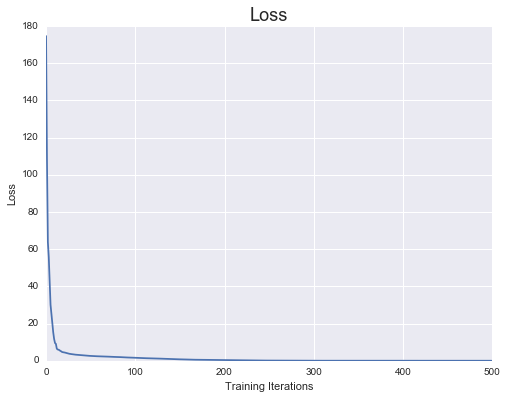

In [78]:
nn.plot_loss()

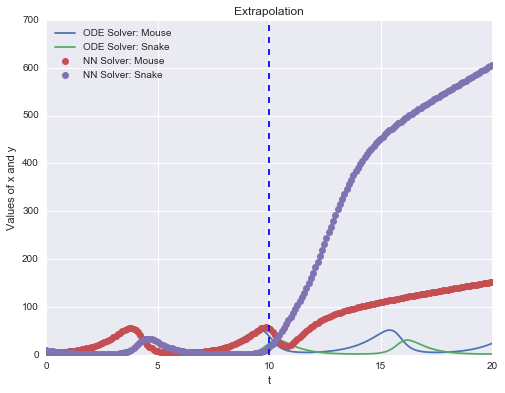

In [176]:
t_test = np.linspace(0., 20.0, 200).reshape(-1,1)

sol = solve_ivp(f, [t_test.min(), t_test.max()], y0_list, method='Radau', rtol=1e-5)
y_pred_list, dydt_pred_list = nn.predict(t=t_test)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label='ODE Solver: Mouse')
plt.plot(sol.t, sol.y[1], label='ODE Solver: Snake')

plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver: Mouse')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver: Snake')
plt.axvline(x = 10 , linestyle = '--')
plt.legend(loc = 'best')
plt.title('Extrapolation')
plt.ylabel('Values of x and y')
plt.xlabel('t')

# Performance over 100 Fittings

In [45]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)]))
    

iteration: 0 loss:  1896.656981
iteration: 200 loss:  0.0442715139991
         Current function value: 0.015935
         Iterations: 342
         Function evaluations: 409
         Gradient evaluations: 397
iteration: 0 loss:  256.662077974
         Current function value: 0.427886
         Iterations: 129
         Function evaluations: 188
         Gradient evaluations: 176
iteration: 0 loss:  371.326509761
iteration: 200 loss:  0.00307164655739
iteration: 400 loss:  0.000113104227195
         Current function value: 0.000066
         Iterations: 500
         Function evaluations: 551
         Gradient evaluations: 551
iteration: 0 loss:  988.310048715
iteration: 200 loss:  0.0552579503225
         Current function value: 0.037494
         Iterations: 269
         Function evaluations: 344
         Gradient evaluations: 332
iteration: 0 loss:  289.876637042
iteration: 200 loss:  0.046052901226
         Current function value: 0.032875
         Iterations: 337
         Function evaluat

(array([ 13.,  14.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
        65.,   2.,   0.,   1.]), array([  0.56853557,   2.14933351,   3.73013145,   5.31092939,
         6.89172733,   8.47252527,  10.05332321,  11.63412116,
        13.2149191 ,  14.79571704,  16.37651498,  17.95731292,
        19.53811086,  21.1189088 ,  22.69970674,  24.28050469]), <a list of 15 Patch objects>)


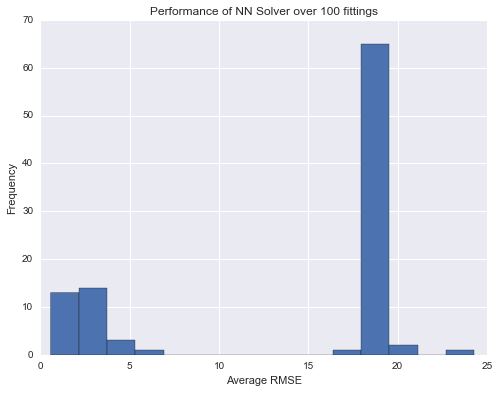

In [47]:
plt.figure(figsize= (8, 6))
figr = plt.hist(res_arr, bins=15)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figr)

# 3-species LV

In [121]:
# define ODE problem
# Lotka–Volterra equations

def f(t, y):
    # du/dt = au -buv
    # dv/dt = -cv + dbu*v
    # http://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
    a = 1.
    b = 1
    c = 1
    d = 1
    e = 1
    f = 1
    g = 1
    
    X = y[0]
    Y = y[1]
    Z = y[2]
    
    return [a*X - b*X*Y, -c*Y + d*X*Y - e*Y*Z, -f*Z+ g*Y*Z ]

t = np.linspace(0, 10, 100).reshape(-1, 1) #increase training points

y0_list = [0.5, 1,  2] # number of prey and predactor respectively

## Reference Solution from ODE Solver

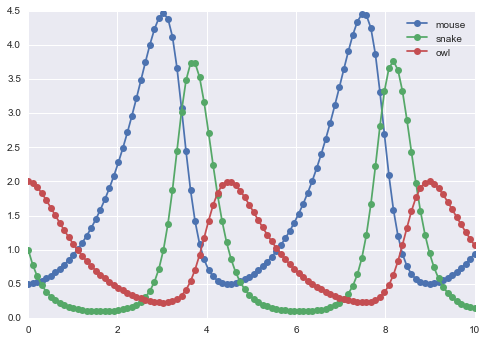

In [122]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='mouse')
plt.plot(sol.t, sol.y[1], marker='o', label='snake')
plt.plot(sol.t, sol.y[2], marker = 'o', label = 'owl')
plt.legend()

iteration: 0 loss:  2148262.7517
iteration: 100 loss:  0.0320205665275
iteration: 200 loss:  0.0266775651589
iteration: 300 loss:  0.0200230455905
iteration: 400 loss:  0.0171741645958
         Current function value: 0.014979
         Iterations: 500
         Function evaluations: 573
         Gradient evaluations: 573


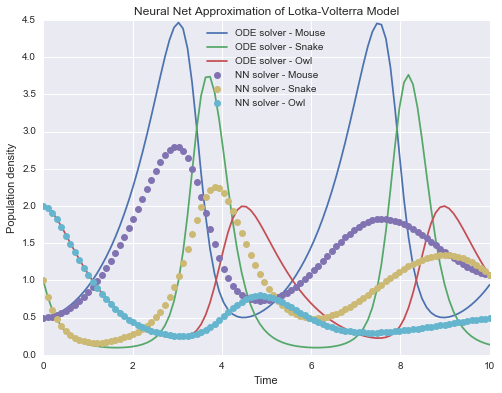

In [123]:
nn = NNSolver(f, t, y0_list, n_hidden=50)
nn.reset_weights()
nn.train(maxiter=500, iprint=100)

y_pred_list, dydt_pred_list = nn.predict()

plt.figure(figsize= (8, 6))
# scipy sol
plt.plot(sol.t, sol.y[0], label='ODE solver - Mouse')
plt.plot(sol.t, sol.y[1], label='ODE solver - Snake')
plt.plot(sol.t, sol.y[2], label='ODE solver - Owl')

# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN solver - Mouse')
plt.plot(t, y_pred_list[1], 'o', label='NN solver - Snake')
plt.plot(t, y_pred_list[2], 'o', label='NN solver - Owl')

plt.legend(loc = "best")
plt.title('Neural Net Approximation of Lotka-Volterra Model')
plt.xlabel('Time')
plt.ylabel('Population density')
#plt.xlim((0, 10.1))

## Average RMSE

In [124]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(3)])

0.79963306262237754

## Loss

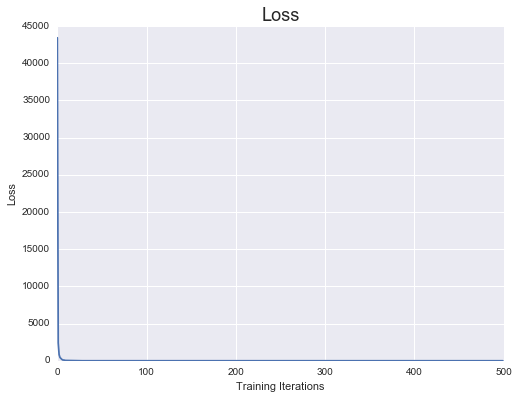

In [112]:
nn.plot_loss()

## Extrapolation

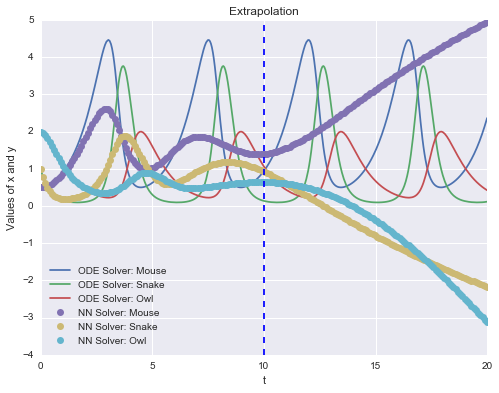

In [113]:
t_test = np.linspace(0., 20.0, 200).reshape(-1,1)

sol = solve_ivp(f, [t_test.min(), t_test.max()], y0_list, method='Radau', rtol=1e-5)
y_pred_list, dydt_pred_list = nn.predict(t=t_test)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label='ODE Solver: Mouse')
plt.plot(sol.t, sol.y[1], label='ODE Solver: Snake')
plt.plot(sol.t, sol.y[2], label='ODE Solver: Owl')
plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver: Mouse')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver: Snake')
plt.plot(t_test, y_pred_list[2], 'o', label='NN Solver: Owl')
plt.axvline(x = 10 , linestyle = '--')
plt.legend(loc = 'best')
plt.title('Extrapolation')
plt.ylabel('Values')
plt.xlabel('t')

# Performance over 100 Fittings

In [125]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(3)]))

iteration: 0 loss:  35289.1682894
iteration: 200 loss:  0.0308851016104
iteration: 400 loss:  0.0017501158069
         Current function value: 0.000305
         Iterations: 500
         Function evaluations: 557
         Gradient evaluations: 557
iteration: 0 loss:  288866.678576
iteration: 200 loss:  0.0249339701187
iteration: 400 loss:  0.0188742398327
         Current function value: 0.011041
         Iterations: 500
         Function evaluations: 572
         Gradient evaluations: 572
iteration: 0 loss:  7383.64099153
iteration: 200 loss:  0.0274415735462
iteration: 400 loss:  0.0207630144468
         Current function value: 0.020340
         Iterations: 500
         Function evaluations: 552
         Gradient evaluations: 552
iteration: 0 loss:  19.0399883033
iteration: 200 loss:  0.0246584853157
iteration: 400 loss:  0.0152530703286
         Current function value: 0.005901
         Iterations: 500
         Function evaluations: 545
         Gradient evaluations: 545
iteration: 0

(array([ 33.,   4.,  37.,  24.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   1.]), array([ 0.76567321,  0.98891039,  1.21214757,  1.43538475,  1.65862193,
        1.88185911,  2.10509629,  2.32833347,  2.55157065,  2.77480783,
        2.99804501,  3.22128219,  3.44451937,  3.66775655,  3.89099373,
        4.11423091,  4.33746809,  4.56070527,  4.78394245,  5.00717963,
        5.23041681,  5.45365399,  5.67689117,  5.90012835,  6.12336553,
        6.34660271,  6.56983989,  6.79307707,  7.01631425,  7.23955143,
        7.46278861,  7.68602579,  7.90926297,  8.13250015,  8.35573733,
        8.57897451,  8.80221169,  9.02544887,  9.24868605,  9.47192323,
        9.69516041]), <a list of 40 Patch objects>)


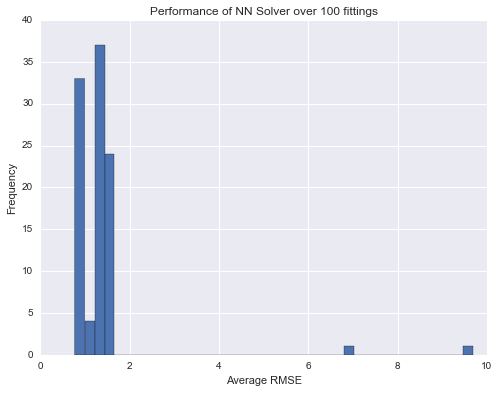

In [127]:
# the following plot doesn't seem to mean much
# given the fitting was bad to start with
plt.figure(figsize= (8, 6))
figr = plt.hist(res_arr, bins=40)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figr)